In [95]:
import numpy as np
import pandas as pd
from scipy import optimize
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Rectangle
import seaborn as sns
import time
import KM_EWS_methods
import importlib
importlib.reload(KM_EWS_methods)

<module 'KM_EWS_methods' from '/Users/andreasmorr/Library/Mobile Documents/com~apple~CloudDocs/PhD Studium/Eigene Papers/KramersMoyalEWS/KramersMoyalEWS/KM_EWS_methods.py'>

Plot specifications

In [96]:
plt.rcParams['pgf.texsystem'] = 'pdflatex'
plt.rcParams.update({'font.family': 'serif',
                     'text.usetex': True,
                     'font.serif': ['Helvetica'],
                     'font.size': 2*8,
                     'axes.labelsize': 2*8,
                     'axes.titlesize': 2*12,
                     'figure.titlesize': 2*14})

OU-data generator

In [97]:
def OU_sample(T,Delta_t,lambda_,sigma_=1):
    this_sample = np.zeros(round(T/Delta_t))
    this_sample[0] = np.random.normal(0,np.sqrt(sigma_**2/(2*lambda_)))
    for i in range(round(T/Delta_t) - 1):
        this_sample[i+1] = np.exp(-lambda_*Delta_t)*this_sample[i] + np.sqrt(sigma_**2/(2*lambda_)*(1-np.exp(-2*lambda_*Delta_t)))*np.random.normal()
    return this_sample

Calculate the 95% interval of the estimator distributions

In [98]:
def estimator_dist_width(estimator, lambda_, T, Delta_t, samplesize = 1000, confidence=0.95):
    samples = [OU_sample(T, Delta_t, lambda_) for i in range(samplesize)]
    estimator_results = [estimator(this_sample) for this_sample in samples]
    estimator_results.sort()
    return [estimator_results[round(samplesize*(1-confidence)/2)],estimator_results[round(samplesize*(confidence+(1-confidence)/2))]]

Check for a selection of Ts and Delta_ts whether the confidence intervals overlap

In [99]:
Ts = [50, 75, 100, 125, 150]
Delta_ts = [1, 0.8, 0.6, 0.4, 0.2, 0.1]
lambda_start = 1
lambda_end = 0.1

variance_df = [[] for i in range(len(Ts))]
ac1_df = [[] for i in range(len(Ts))]
lambda_df = [[] for i in range(len(Ts))]
for i in range(len(Ts)):
    for Delta_t in Delta_ts:
        variance_df[i].append(estimator_dist_width(KM_EWS_methods.variance_estimator, lambda_=lambda_start, T=Ts[i], Delta_t=Delta_t)[1]<estimator_dist_width(KM_EWS_methods.variance_estimator, lambda_=lambda_end, T=Ts[i], Delta_t=Delta_t)[0])
        ac1_df[i].append(estimator_dist_width(KM_EWS_methods.ac1_estimator, lambda_=lambda_start, T=Ts[i], Delta_t=Delta_t)[1]<estimator_dist_width(KM_EWS_methods.ac1_estimator, lambda_=lambda_end, T=Ts[i], Delta_t=Delta_t)[0])
        lambda_df[i].append(estimator_dist_width(KM_EWS_methods.lambda_estimator, lambda_=lambda_start, T=Ts[i], Delta_t=Delta_t)[0]>estimator_dist_width(KM_EWS_methods.lambda_estimator, lambda_=lambda_end, T=Ts[i], Delta_t=Delta_t)[1])

variance_df = pd.DataFrame(variance_df,index=Ts, columns=Delta_ts)
ac1_df = pd.DataFrame(ac1_df,index=Ts, columns=Delta_ts)
lambda_df = pd.DataFrame(lambda_df,index=Ts, columns=Delta_ts)

Plot heat maps

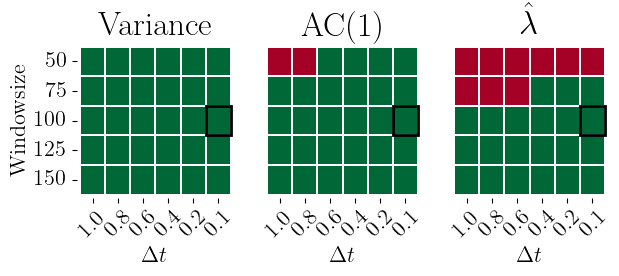

In [100]:
cmap = matplotlib.colormaps["RdYlGn"]
fig, axs = plt.subplots(1, 3, figsize=(2*3.42, 2*1))
axs[0].set_title("Variance")
sns.heatmap(variance_df, ax = axs[0],cbar=False, cmap=cmap, vmin=0, vmax=1, linewidths=0.01)
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation = 45)
axs[0].add_patch(Rectangle((5,2),1,1,fill=False,edgecolor="black", lw=2))
axs[0].set_xlim([-0.1,6.1])
axs[0].set_ylim([5.1,-0.1])
axs[0].set_xlabel("$\Delta t$")
axs[0].set_ylabel("Windowsize")
axs[1].set_title("AC(1)")
sns.heatmap(ac1_df, ax = axs[1],cbar=False, cmap=cmap, vmin=0, vmax=1, linewidths=0.01)
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation = 45)
axs[1].add_patch(Rectangle((5,2),1,1,fill=False,edgecolor="black", lw=2))
axs[1].set_xlim([-0.1,6.1])
axs[1].set_ylim([5.1,-0.1])
axs[1].set_xlabel("$\Delta t$")
axs[1].set_yticks([])
axs[2].set_title("$\hat\lambda$")
sns.heatmap(lambda_df, ax = axs[2],cbar=False, cmap=cmap, vmin=0, vmax=1, linewidths=0.01)
axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation = 45)
axs[2].add_patch(Rectangle((5,2),1,1,fill=False,edgecolor="black", lw=2))
axs[2].set_xlim([-0.1,6.1])
axs[2].set_ylim([5.1,-0.1])
axs[2].set_xlabel("$\Delta t$")
axs[2].set_yticks([])


plt.show()
#fig.savefig("Plots/EstimatorSensitivity" + time.strftime("%Y%m%d-%H%M%S") + '.pdf', transparent=True, bbox_inches='tight')

Plot histograms for one choice of T and Delta_t

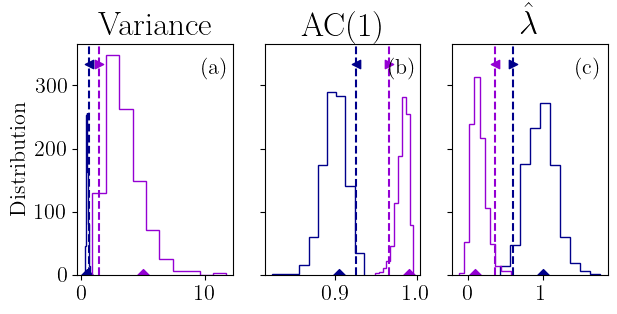

In [103]:
T = 100
Delta_t = 0.1
samplesize = 1000
confidence = 0.95
estimators = [KM_EWS_methods.variance_estimator, KM_EWS_methods.ac1_estimator, KM_EWS_methods.lambda_estimator]
lambda_start = 1
lambda_end = 0.1

color_start = "darkblue"
color_end = "darkviolet"


props = dict(edgecolor="none", facecolor='white', alpha=0)
fig, axs = plt.subplots(1, 3, figsize=(2*3.42, 2*1.5),sharey=True)
samples_start = [OU_sample(T, Delta_t, lambda_=lambda_start) for i in range(samplesize)]
samples_end = [OU_sample(T, Delta_t, lambda_=lambda_end) for i in range(samplesize)]
for i in range(3):
    estimator_results_start = np.array([estimators[i](this_sample) for this_sample in samples_start])
    estimator_results_start.sort()
    estimator_results_end = np.array([estimators[i](this_sample) for this_sample in samples_end])
    estimator_results_end.sort()
    if i == 2:
        estimator_results_start = estimator_results_start/Delta_t
        estimator_results_end = estimator_results_end/Delta_t
        axs[i].axvline(estimator_results_start[round(samplesize*(1-confidence)/2)],color=color_start,linestyle = "dashed")
        axs[i].axvline(estimator_results_end[round(samplesize*(confidence+(1-confidence)/2))],color=color_end,linestyle = "dashed")
        axs[i].scatter([estimator_results_start[round(samplesize*(1-confidence)/2)]],[samplesize/3],c=color_start,marker=">")
        axs[i].scatter([estimator_results_end[round(samplesize*(confidence+(1-confidence)/2))]],[samplesize/3],c=color_end,marker="<")
    else:
        axs[i].axvline(estimator_results_end[round(samplesize*(1-confidence)/2)],color=color_end,linestyle = "dashed")
        axs[i].axvline(estimator_results_start[round(samplesize*(confidence+(1-confidence)/2))],color=color_start,linestyle = "dashed")
        axs[i].scatter([estimator_results_end[round(samplesize*(1-confidence)/2)]],[samplesize/3],c=color_end,marker=">")
        axs[i].scatter([estimator_results_start[round(samplesize*(confidence+(1-confidence)/2))]],[samplesize/3],c=color_start,marker="<")
    axs[i].hist(estimator_results_start,histtype="step",color=color_start)
    axs[i].hist(estimator_results_end,histtype="step",color=color_end)
axs[0].set_title("Variance")
axs[0].scatter([1/(2*lambda_start)],[0],c=color_start,marker="D")
axs[0].scatter([1/(2*lambda_end)],[0],c=color_end,marker="D")
axs[0].set_ylabel("Distribution")
axs[0].text(0.8, 0.94, "(a)", transform=axs[0].transAxes, verticalalignment='top', bbox=props)
axs[1].set_title("AC(1)")
axs[1].scatter([np.exp(-lambda_start*Delta_t)],[0],c=color_start,marker="D")
axs[1].scatter([np.exp(-lambda_end*Delta_t)],[0],c=color_end,marker="D")
axs[1].text(0.8, 0.94, "(b)", transform=axs[1].transAxes, verticalalignment='top', bbox=props)
axs[2].set_title("$\hat\lambda$")
axs[2].scatter([lambda_start],[0],c=color_start,marker="D")
axs[2].scatter([lambda_end],[0],c=color_end,marker="D")
axs[2].text(0.8, 0.94, "(c)", transform=axs[2].transAxes, verticalalignment='top', bbox=props)

plt.show()
#fig.savefig("Plots/EstimatorDistributions" + time.strftime("%Y%m%d-%H%M%S") + '.pdf', transparent=True, bbox_inches='tight')

Plot lambda estimator distributions for different parameter choices

In [102]:
bin_numbers = [50]
bws = [0.1,0.2,0.3,0.4,0.5,0.6,1,2,3,4,5,6,7,8]
centerkmfractions = [0.5]

samplesize = 1000
Delta_t = 0.1
lambda_ = 1
confidence = 0.95

samples = [OU_sample(T, Delta_t, lambda_) for i in range(samplesize)]
sample_std = np.mean(np.array([np.std(samples[i]) for i in range(samplesize)]))

def lambda_dist_width(params, samples, Delta_t):
    bin_number = int(params[0])
    bw = params[1]
    centerkmfraction = params[2]
    estimator_results = [KM_EWS_methods.lambda_estimator(this_sample, Delta_t, bin_number, bw, centerkmfraction) for this_sample in samples]
    estimator_results.sort()
    return np.std(estimator_results)

lowest_width = 10
for bin_number in bin_numbers:
    for bw in bws:
        for centerkmfraction in centerkmfractions:
            width = lambda_dist_width([bin_number, bw, centerkmfraction], samples, Delta_t)
            if width < lowest_width:
                lowest_width = width
            print(width)
            print([bin_number, bw/sample_std, centerkmfraction])
print(lowest_width)
#print(optimize.fmin(lambda_dist_width, [40, 0.05, 0.6], args=(samples, Delta_t)).x)

0.20157890951808446
[50, 0.14296812859736951, 0.5]
0.18092134988924188
[50, 0.28593625719473903, 0.5]
0.16533853809120524
[50, 0.4289043857921085, 0.5]
0.14970449045437875
[50, 0.5718725143894781, 0.5]
0.13432150777974383
[50, 0.7148406429868475, 0.5]
0.12082554344684826
[50, 0.857808771584217, 0.5]
0.07547092653222666
[50, 1.429681285973695, 0.5]
0.02300128339336697
[50, 2.85936257194739, 0.5]
0.00944099101869021
[50, 4.289043857921085, 0.5]
0.005462627929582974
[50, 5.71872514389478, 0.5]
0.0032389940461269224
[50, 7.148406429868475, 0.5]
0.0021614471605670396
[50, 8.57808771584217, 0.5]
0.0014984560627659068
[50, 10.007769001815864, 0.5]
0.0010992425802497413
[50, 11.43745028778956, 0.5]
0.0010992425802497413
